In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math 
from matplotlib.patches import Ellipse
#for removing warnings
import warnings

# Model data 

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
#data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path1 = 's3://velocity-u.zarr'
data_path2 = 's3://velocity-v.zarr'
data_path3 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

du = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dzz = xr.open_zarr(store=store3, consolidated=True)

In [3]:
moor_l = [(836, 440),
            (838, 440),
            (836, 439),
            (923, 157), #Denne fikk nan value, hvorfor??
            (930, 149),
            (932, 147),
            (929, 142),
            (774, 344+6),
            (766, 358+6),
            (773, 346+6),
            (334, 978)]

vec_l = [np.array([[ 0.98798697, -0.15453721],
        [ 0.15453721,  0.98798697]]), 
         np.array([[ 0.99999737, -0.00229451],
       [ 0.00229451,  0.99999737]]), 
         np.array([[ 0.99797779,  0.06356359],
       [-0.06356359,  0.99797779]]),
         np.array([[ 0.92383114, -0.38280025],
       [ 0.38280025,  0.92383114]]), 
          np.array([[-0.43408703, -0.90087094],
       [-0.90087094,  0.43408703]]), 
         np.array([[-0.09707457, -0.99527711],
       [-0.99527711,  0.09707457]]), 
         np.array([[-0.15963378, -0.9871763 ],
       [-0.9871763 ,  0.15963378]]), 
         np.array([[ 0.81018397, -0.58617568],
       [ 0.58617568,  0.81018397]]), 
         np.array([[ 0.97174756,  0.23602264],
       [-0.23602264,  0.97174756]]), 
         np.array([[ 0.84664665, -0.53215547],
       [ 0.53215547,  0.84664665]]), 
         np.array([[-0.55791922, -0.82989526],
       [-0.82989526,  0.55791922]])]

main_l = [0.0031375185892436137,
         0.002522691813550732, 
         0.0022871371172146705,
          
         0.07647687208041684, 
         0.08672609597829996, 
         0.07058107540719372, 
         0.04864753980612831, 
         0.0400218520307875,
         0.01527001149843686, 
         0.041980634696618606, 
         0.0663464415345908]
min_l = [0.0011184907299555621,
         0.0010488440461297911,
         0.000943591964737983, 
         0.05576082377307558,
         0.03430598931396933,
         0.01825392254775858, 
         0.01498030195653885, 
         0.026319144262834215, 
         0.007239953032162382, 
         0.020282444514094437, 
         0.018783670816590735]
theta_l = [8.889956888630655, 
           0.131465823410729, 
           -3.6443820733578156, 
           22.5072445139066, 
           -115.7272141805237, 
           -95.5707357979352, 
           -99.18564037010735, 
           35.88608992933248,
           -13.6519112854629, 
           32.15120723975012, 
           -123.91201995198159]

c_list = ['c', 'orangered', 'g',
          'r', 'm', 'y','tab:orange',
          'tab:pink', 'limegreen', 'maroon', 
          'dodgerblue', 'gold', 'peru','deeppink',
          'gold','peru','dodgerblue','c','m']

In [4]:
u = du.vozocrtx.isel(x=slice(200,1400),y=slice(650,1800))
u = u.rename({'depthu' : 'depth'})
v = dv.vomecrty.isel(x=slice(200,1400),y=slice(650,1800))
v = v.rename({'depthv' : 'depth'})

bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800)).squeeze(axis=0)

In [5]:
def PC(data):
    cov = np.cov(data.T, bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]

    return  values, vectors

In [6]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values
    dypu = u.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dypv = v.isel(x=x, y=y, depth = slice(0,d-1))
    
    valu, vecu = PC(dypu)
    valv, vecv = PC(dypv)
    
    PC1u = (np.sqrt(valu[0])*vecu[:,0])
    PC1v = (np.sqrt(valv[0])*vecv[:,0])
    
    PVE1u = int(round(valu[0]/np.sum(valu)*100,0))
    PVE1v = int(round(valv[0]/np.sum(valv)*100,0))
    
    return PC1u, PC1v, dypu, dypv, PVE1u, PVE1v

def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values

    dypu = u.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dypv = v.isel(x=x, y=y, depth = slice(15,d-1))
    
    #feil her med vec val
    vecu, valu = PCz(dypu)
    vecv, valv = PCz(dypv)
    
    PC1u = (np.sqrt(valu[0])*vecu[:,0])
    PC1v = (np.sqrt(valv[0])*vecv[:,0])
    
    PVE1u = int(round(valu[0]/np.sum(valu)*100,0))
    PVE1v = int(round(valv[0]/np.sum(valv)*100,0))
    
    return PC1u, PC1v, dypu, dypv, PVE1u, PVE1v

'Making a function for the vertical PC'
def PCz_op(x,y, vec):
    
    d = bathym.isel(y=y, x=x).values
    up = u.isel(y=y, x=x, depth=slice(0,d-1))
    vp = v.isel(y=y, x=x, depth=slice(0,d-1))
    print(vec[0],vec[1])
    print(up.shape)
    
    vel_p = (up*vec[0] + vp*vec[1])/(np.sqrt(vec[0]**2 + vec[1]**2))
    vel_o = (-up*vec[1] + vp*vec[0])/(np.sqrt(vec[0]**2 + vec[1]**2))
    
    valp, vecp = PC(vel_p)
    valo, veco = PC(vel_o)
    
    PC1p = (np.sqrt(valp[0])*vecp[:,0])
    PC1o = (np.sqrt(valo[0])*veco[:,0])
    
    PVE1p = int(round(valp[0]/np.sum(valp)*100,0))
    PVE1o = int(round(valo[0]/np.sum(valo)*100,0))
    
    return PC1p, PC1o, up, vp, PVE1p, PVE1o

def ellipse(x,y,d):
    
    #d = bathym.isel(y=y, x=x).values
    covm = np.cov(np.vstack([u.isel(x=x, y=y, depth=d).values,v.isel(x=x, y=y, depth=d).values]))
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    
    # ellipser :
    major = np.sqrt(values[0])
    minor = np.sqrt(np.abs(values[1]))
    
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    #theta = np.arctan(vy/vx)#*(180/math.pi)
    theta = np.arctan2(vy, vx)*(180/math.pi)
    
    return major, minor, theta, vectors

d_l = [22,22,22,40,40,40,40,40,35,35,18] 
maj_l = []
min_l = []
theta_l = []
vec_l = []

for i, m in enumerate(moor_l):
    print(i)
    x = m[0]
    y = m[1]
    d_ = d_l[i]
    maj_, min_, theta_, vec_ = ellipse(x,y,d_)
    maj_l.append(maj_)
    min_l.append(min_)
    theta_l.append(theta_)
    vec_l.append(vec_)  

# starting with horizontal variance ellipses 

fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title(f'Horizontal variance ellipses of the current at 86 meters depth')
ax.contour(bathym, colors='grey',levels=8, linewidths=0.4)

for i,m in enumerate(moor_l):
    y = m[0]
    x = m[1]
    vec_ = vec_l[i][:,0]
    maj_ = main_l[i]
    min_ = min_l[i]
    theta_ = theta_l[i]
    
    
    #PVE = round((maj_**2/(maj_**2+ min_**2))*100,0) 
    #velocity = round((maj_/(maj_+ min_)),2) 
    #print(velocity)
    s = 0.5e4 #stands for scale
    
    ellipse_ = Ellipse((y,x), 
            width = maj_*2*s, 
            height = min_*2*s,
            angle = theta_,
            facecolor = 'none',
            edgecolor='k'
            #,label= f'PEV {PVE}%'
                     )
    ax.add_patch(ellipse_)
    ax.legend(frameon=False, fontsize=12, loc="upper left") 

ax.set_aspect('equal')
plt.savefig('mood_ellipse_moor_loc.pdf', dpi = 300)  

# EOF Vertical and EOF rotated with major and minor axis from horizontal ellipses

0.98798697 0.15453721
(73, 29)
0.99999737 0.00229451
(73, 28)
0.99797779 -0.06356359
(73, 28)


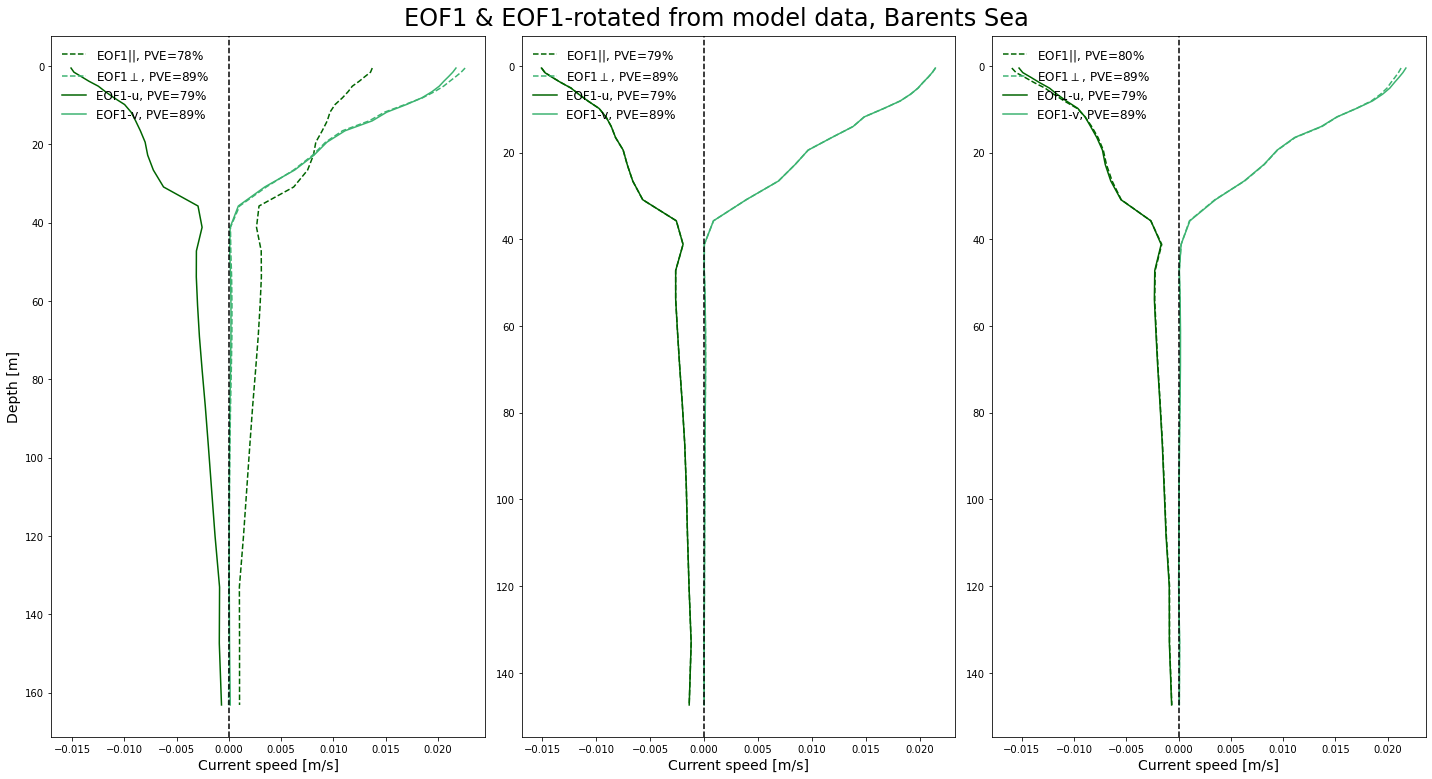

In [7]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,11))
plt.suptitle('EOF1 & EOF1-rotated from model data, Barents Sea', 
             horizontalalignment='center',
            fontsize=24)

axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [0,1,2]):
    x = moor_l[i][0]
    y = moor_l[i][1]
    vec = vec_l[i][:,0]  
    PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
    axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen')
    axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=12, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
fig.tight_layout()   

plt.savefig('EOFs_Barents_mod.pdf', dpi = 300)

0.92383114 0.38280025
(73, 59)
-0.43408703 -0.90087094
(73, 49)
-0.09707457 -0.99527711
(73, 39)
-0.15963378 -0.9871763
(73, 39)


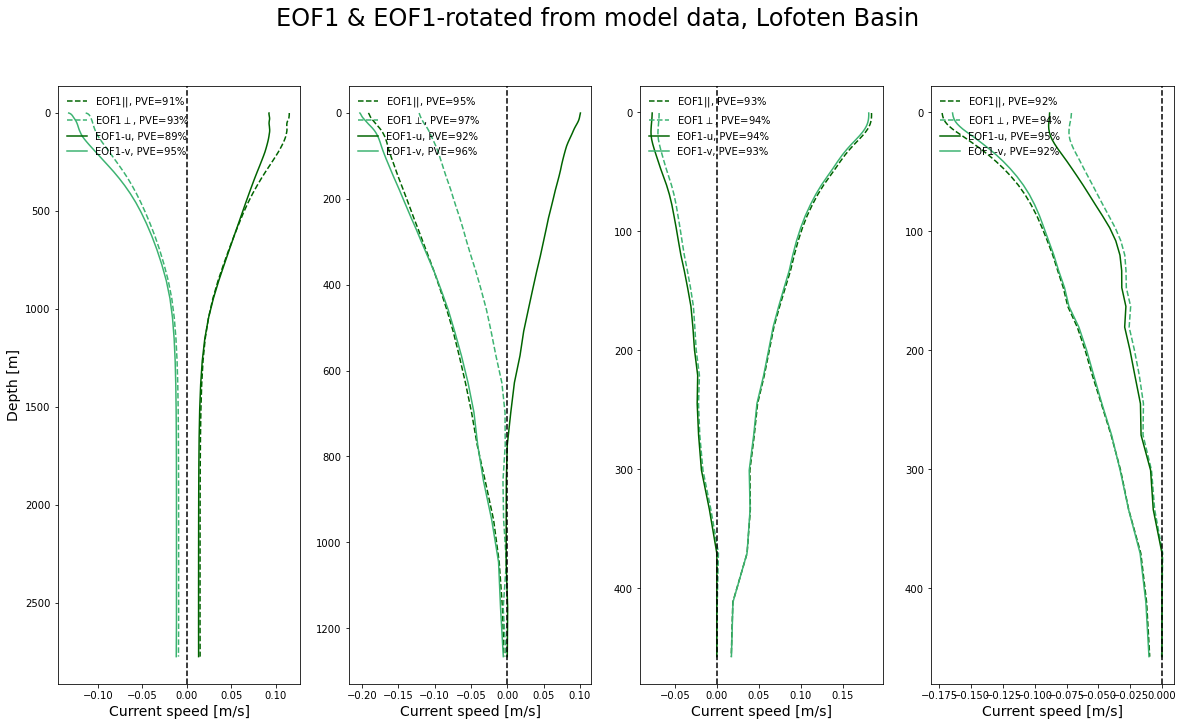

In [8]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (20,11))
plt.suptitle('EOF1 & EOF1-rotated from model data, Lofoten Basin', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [3,4,5,6]):
    x = moor_l[i][0]
    y = moor_l[i][1]
    vec = vec_l[i][:,0]  
    PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
    axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen')
    axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFs_Lofoten_mod.pdf', dpi = 300)

0.81018397 0.58617568
(73, 50)
0.97174756 -0.23602264
(73, 41)
0.84664665 0.53215547
(73, 48)


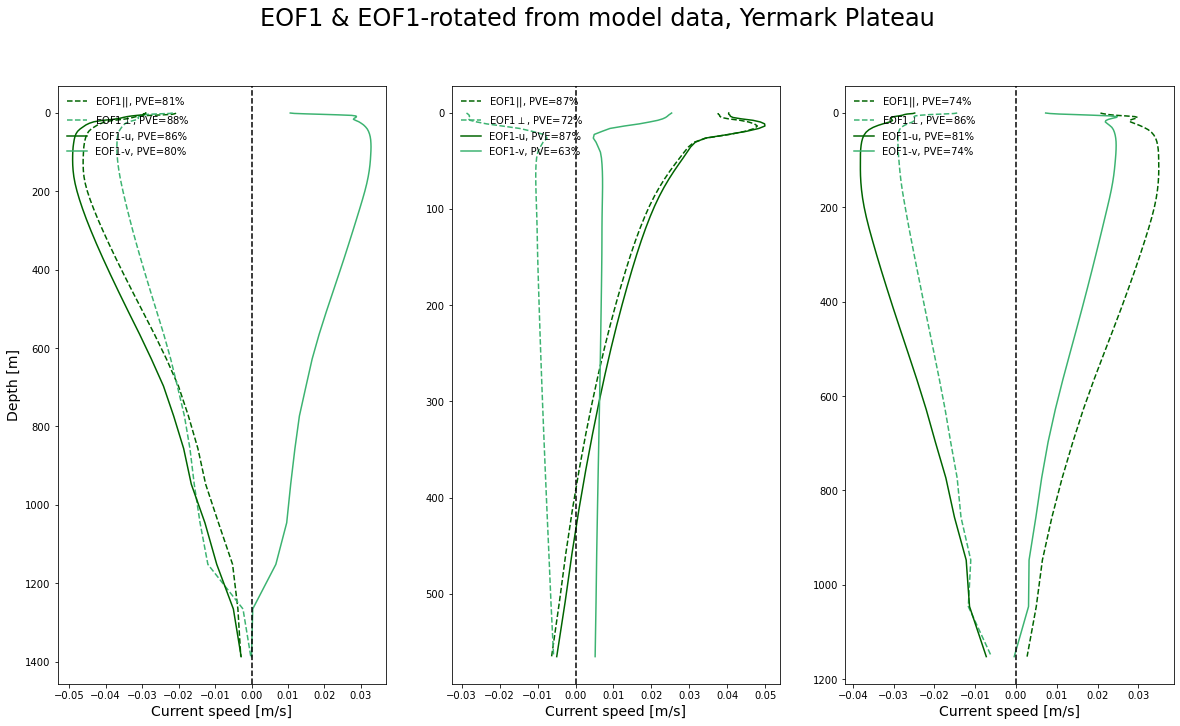

In [9]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,11))
plt.suptitle('EOF1 & EOF1-rotated from model data, Yermark Plateau', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat,[7,8,9]):
    x = moor_l[i][0]
    y = moor_l[i][1]
    vec = vec_l[i][:,0]  
    PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
    axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen')
    axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFs_Yermark_mod.pdf', dpi = 300)

-0.55791922 -0.82989526
(73, 22)


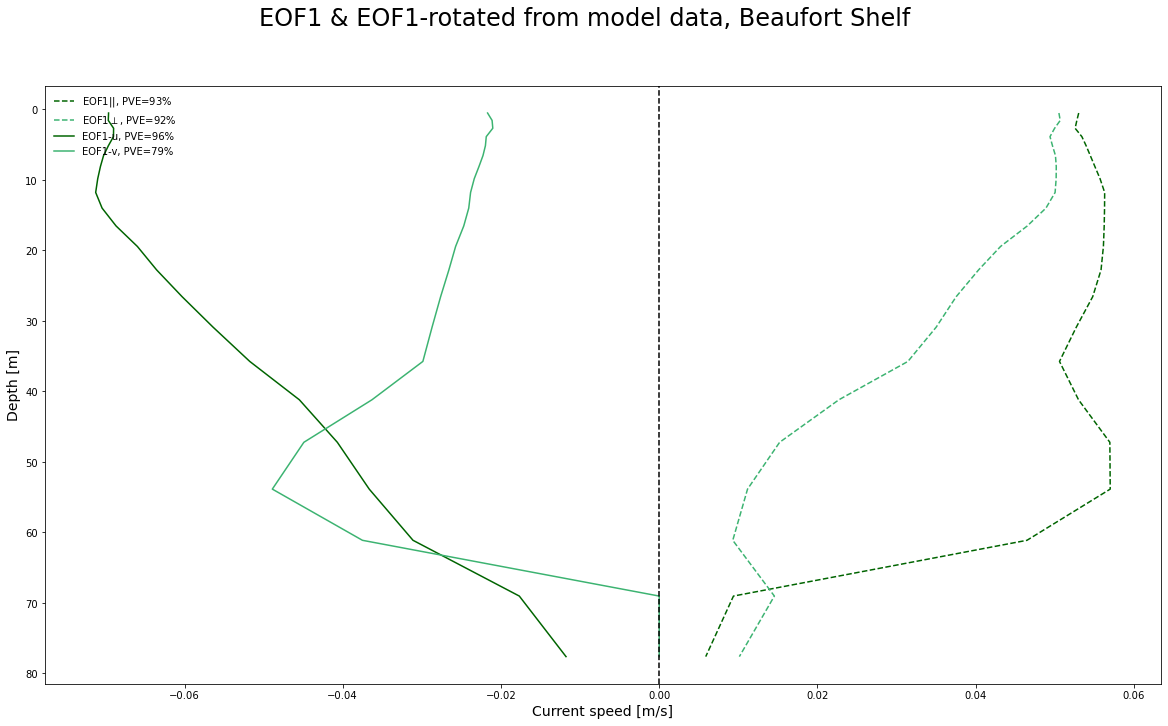

In [10]:
warnings.simplefilter("ignore")
fig, axs = plt.subplots(figsize = (20,11))
plt.suptitle('EOF1 & EOF1-rotated from model data, Beaufort Shelf', 
             horizontalalignment='center',
            fontsize=24)
axs.set_ylabel('Depth [m]', fontsize=14)
x = moor_l[10][0]
y = moor_l[10][1]
vec = vec_l[10][:,0]  
PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen')
axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
axs.axvline(0, color='k', linestyle = '--')
axs.legend(frameon=False, fontsize=10, loc="upper left") 
axs.invert_yaxis()
axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFs_Beaufort_mod.pdf', dpi = 300)